## IBM Quantum Challenge Fall 2021
# Challenge 4: Battery revenue optimization

<div class="alert alert-block alert-info">
    
We recommend that you switch to **light** workspace theme under the Account menu in the upper right corner for optimal experience.

# Introduction to QAOA

When it comes to optimization problems, a well-known algorithm for finding approximate solutions to combinatorial-optimization problems is **QAOA (Quantum approximate optimization algorithm)**. You may have already used it once in the finance exercise of Challenge-1, but still don't know what it is. In this challlenge we will further learn about QAOA----how does it work? Why we need it?

First off, what is QAOA?  Simply put, QAOA is a classical-quantum  hybrid algorithm that combines a parametrized quantum circuit known as ansatz, and a classical part to optimize those circuits proposed by Farhi, Goldstone, and Gutmann (2014)[**[1]**](https://arxiv.org/abs/1411.4028). 

It is a variational algorithm that uses a unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ characterized by the parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ to prepare a quantum state $|\psi(\boldsymbol{\beta}, \boldsymbol{\gamma})\rangle$. The goal of the algorithm is to find optimal parameters $(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt})$ such that the quantum state $|\psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt})\rangle$ encodes the solution to the problem. 

The unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ has a specific form and is composed of two unitaries $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ and $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$ where $H_{B}$ is the mixing Hamiltonian and $H_{P}$ is the problem Hamiltonian. Such a choice of unitary drives its inspiration from a related scheme called quantum annealing.

The state is prepared by applying these unitaries as alternating blocks of the two unitaries applied $p$ times such that 

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) 
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} 
\lvert \psi_0 \rangle$$

where $|\psi_{0}\rangle$ is a suitable initial state.

<center><img src="resources/qaoa_circuit.png" width="600"></center>

The QAOA implementation of Qiskit directly extends VQE and inherits VQE’s general hybrid optimization structure.
To learn more about QAOA, please refer to the [**QAOA chapter**](https://qiskit.org/textbook/ch-applications/qaoa.html) of Qiskit Textbook.

<div class="alert alert-block alert-success">

**Goal**

Implement the quantum optimization code for the battery revenue problem. <br>
<br>
**Plan**

First, you will learn about QAOA and knapsack problem.
<br><br>
**Challenge 4a** - Simple knapsack problem with QAOA: familiarize yourself with a typical knapsack problem and  find the optimized solution with QAOA.
<br><br>
**Final Challenge 4b** - Battery revenue optimization with Qiskit knapsack class: learn the battery revenue optimization problem and find the optimized solution with QAOA. You can receive a badge for solving all the challenge exercises up to 4b.
<br><br>
**Final Challenge 4c** - Battery revenue optimization with your own quantum circuit: implement the battery revenue optimization problem to find the lowest circuit cost and circuit depth. Achieve better accuracy with smaller circuits. you can obtain a score with ranking by solving this exercise.
</div>

<div class="alert alert-block alert-info">

Before you begin, we recommend watching the [**Qiskit Optimization Demo Session with Atsushi Matsuo**](https://youtu.be/claoY57eVIc?t=104) and check out the corresponding [**demo notebook**](https://github.com/qiskit-community/qiskit-application-modules-demo-sessions/tree/main/qiskit-optimization) to learn how to do classifications using QSVM.

</div>

As we just mentioned, QAOA is an algorithm which can be used to find approximate solutions to combinatorial optimization problems, which includes many specific problems, such as:

- TSP (Traveling Salesman Problem) problem
- Vehicle routing problem
- Set cover problem
- Knapsack problem
- Scheduling problems,etc. 

Some of them are hard to solve (or in another word, they are NP-hard problems), and it is impractical to find their exact solutions in a reasonable amount of time, and that is why we need the approximate algorithm. Next, we will introduce an instance of using QAOA to solve one of the combinatorial optimization problems----**knapsack problem**.

# Knapsack Problem #

[**Knapsack Problem**](https://en.wikipedia.org/wiki/Knapsack_problem) is an optimization problem that goes like this: given a list of items that each has a weight and a value and a knapsack that can hold a maximum weight. Determine which items to take in the knapsack so as to maximize the total value taken without exceeding the maiximum weight the knapsack can hold. The most efficient approach would be a greedy approach, but that is not guaranteed to give the best result.


<center><img src="resources/Knapsack.png" width="400"></center>
    
Image source: [Knapsack.svg.](https://commons.wikimedia.org/w/index.php?title=File:Knapsack.svg&oldid=457280382)

<div id='problem'></div>
<div class="alert alert-block alert-info">
Note: Knapsack problem have many variations, here we will only discuss the 0-1 Knapsack problem: either take an item or not (0-1 property), which is a NP-hard problem. We can not divide one item, or take multiple same items.    
</div>

## Challenge 4a: Simple knapsack problem with QAOA 

<div class="alert alert-block alert-success">
    
**Challenge 4a** <br>
You are given a knapsack with a capacity of 18 and 5 pieces of luggage. When the weights of each piece of luggage $W$ is $w_i = [4,5,6,7,8]$ and the value $V$ is $v_i = [5,6,7,8,9]$, find the packing method that maximizes the sum of the values of the luggage within the capacity limit of 18.


</div>

In [1]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
import numpy as np

## Dynamic Programming Approach ##

A typical classical method for finding an exact solution, the Dynamic Programming approach is as follows:

In [2]:
val = [5,6,7,8,9]
wt = [4,5,6,7,8]
W = 18

In [3]:
def dp(W, wt, val, n):
    k = [[0 for x in range(W + 1)] for x in range(n + 1)]
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                k[i][w] = 0
            elif wt[i-1] <= w:
                k[i][w] = max(val[i-1] + k[i-1][w-wt[i-1]], k[i-1][w])
            else:
                k[i][w] = k[i-1][w]
                
    picks=[0 for x in range(n)]
    volume=W
    for i in range(n,-1,-1):
        if (k[i][volume]>k[i-1][volume]):
            picks[i-1]=1
            volume -= wt[i-1]
    return k[n][W],picks

n = len(val)
print("optimal value:", dp(W, wt, val, n)[0])
print('\n index of the chosen items:')
for i in range(n): 
    if dp(W, wt, val, n)[1][i]: 
        print(i,end=' ')

optimal value: 21

 index of the chosen items:
1 2 3 

The time complexity of this method $O(N*W)$, where $N$ is the number of items and $W$ is the maximum weight of the knapsack. We can solve this problem using an exact solution approach within a reasonable time since the number of combinations is limited, but when the number of items becomes huge, it will be impractical to deal with by using a exact solution approach. 

## QAOA approach ##

Qiskit provides application classes for various optimization problems, including the knapsack problem so that users can easily try various optimization problems on quantum computers. In this exercise, we are going to use the application classes for the `Knapsack` problem here. 

There are application classes for other optimization problems available as well. See [**Application Classes for Optimization Problems**](https://qiskit.org/documentation/optimization/tutorials/09_application_classes.html#Knapsack-problem) for details.

In [4]:
# import packages necessary for application classes.
from qiskit_optimization.applications import Knapsack

To represent Knapsack problem as an optimization problem that can be solved by QAOA, we need to formulate the cost function for this problem.

In [5]:
def knapsack_quadratic_program():
    # Put values, weights and max_weight parameter for the Knapsack()
    
    ##############################
    # Provide your code here

    prob = Knapsack(values = val, weights = wt, max_weight=W)
        
    #
    ##############################
    
    # to_quadratic_program generates a corresponding QuadraticProgram of the instance of the knapsack problem.
    kqp = prob.to_quadratic_program()
    return prob, kqp

prob,quadratic_program=knapsack_quadratic_program()
quadratic_program

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Maximize
 obj: 5 x_0 + 6 x_1 + 7 x_2 + 8 x_3 + 9 x_4
Subject To
 c0: 4 x_0 + 5 x_1 + 6 x_2 + 7 x_3 + 8 x_4 <= 18

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End

We can solve the problem using the classical `NumPyMinimumEigensolver` to find the minimum eigenvector, which may be useful as a reference without doing things by Dynamic Programming; we can also apply QAOA.

In [6]:
# Numpy Eigensolver
meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = meo.solve(quadratic_program)
print('result:\n', result)
print('\n index of the chosen items:', prob.interpret(result)) 

result:
 optimal function value: 21.0
optimal value: [0. 1. 1. 1. 0.]
status: SUCCESS

 index of the chosen items: [1, 2, 3]


In [7]:
# QAOA
seed = 123
algorithm_globals.random_seed = seed
qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=seed, seed_transpiler=seed)

meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
result = meo.solve(quadratic_program)
print('result:\n', result)
print('\n index of the chosen items:', prob.interpret(result)) 

result:
 optimal function value: 21.0
optimal value: [0. 1. 1. 1. 0.]
status: SUCCESS

 index of the chosen items: [1, 2, 3]


You will submit the quadratic program created by your `knapsack_quadratic_program` function.

In [8]:
# Check your answer and submit using the following code
from qc_grader import grade_ex4a
grade_ex4a(quadratic_program)

Grading your answer for 4a. Please wait...

Congratulations 🎉! Your answer is correct.


<div id='problem'></div>
<div class="alert alert-block alert-info">
Note: QAOA finds the approximate solutions, so the solution by QAOA is not always optimal. 
</div>

# Battery Revenue Optimization Problem #

<div id='problem'></div>
<div class="alert alert-block alert-success">
In this exercise we will use a quantum algorithm to solve a real-world instance of a combinatorial optimization problem: Battery revenue optimization problem.   
</div>

Battery storage systems have provided a solution to flexibly integrate large-scale renewable energy (such as wind and solar) in a power system. The revenues from batteries come from different types of services sold to the grid. The process of energy trading of battery storage assets is as follows: A regulator asks each battery supplier to choose a market in advance for each time window. Then, the batteries operator will charge the battery with renewable energy and release the energy to the grid depending on pre-agreed contracts. The supplier makes therefore forecasts on the return and the number of charge/discharge cycles for each time window to optimize its overall return. 

How to maximize the revenue of battery-based energy storage is a concern of all battery storage investors. Choose to let the battery always supply power to the market which pays the most for every time window might be a simple guess, but in reality, we have to consider many other factors. 

What we can not ignore is the aging of batteries, also known as **degradation**. As the battery charge/discharge cycle progresses, the battery capacity will gradually degrade (the amount of energy a battery can store, or the amount of power it can deliver will permanently reduce). After a number of cycles, the battery will reach the end of its usefulness. Since the performance of a battery decreases while it is used, choosing the best cash return for every time window one after the other, without considering the degradation, does not lead to an optimal return over the lifetime of the battery, i.e. before the number of charge/discharge cycles reached.

Therefore, in order to optimize the revenue of the battery, what we have to do is to select the market for the battery in each time window taking both **the returns on these markets (value)**, based on price forecast, as well as expected battery **degradation over time (cost)** into account ——It sounds like solving a common optimization problem, right?

We will investigate how quantum optimization algorithms could be adapted to tackle this problem.


<div>
<p></p>
<center><img src="resources/renewable-g7ac5bd48e_640.jpg" width="600"></center>

</div>

Image source: [pixabay](https://pixabay.com/photos/renewable-energy-environment-wind-1989416/)

## Problem Setting

Here, we have referred to the problem setting in de la Grand'rive and Hullo's paper [**[2]**](https://arxiv.org/abs/1908.02210).

Considering two markets $M_{1}$ , $M_{2}$, during every time window (typically a day), the battery operates on one or the other market, for a maximum of $n$ time windows. Every day is considered independent and the intraday optimization is a standalone problem: every morning the battery starts with the same level of power so that we don’t consider charging problems. Forecasts on both markets being available for the $n$ time windows, we assume known for each time window $t$ (day) and for each market:

- the daily returns $\lambda_{1}^{t}$ , $\lambda_{2}^{t}$

- the daily degradation, or health cost (number of cycles), for the battery $c_{1}^{t}$, $c_{2}^{t}$ 

We want to find the optimal schedule, i.e. optimize the life time return with a cost less than $C_{max}$ cycles. We introduce $d = max_{t}\left\{c_{1}^{t}, c_{2}^{t}\right\} $.

We introduce the decision variable $z_{t}, \forall t \in [1, n]$ such that $z_{t} = 0$ if the supplier chooses $M_{1}$ , $z_{t} = 1$ if choose $M_{2}$, with every possible vector $z = [z_{1}, ..., z_{n}]$ being a possible schedule. The previously formulated problem can then be expressed as:


\begin{equation}
\underset{z \in \left\{0,1\right\}^{n}}{max} \displaystyle\sum_{t=1}^{n}(1-z_{t})\lambda_{1}^{t}+z_{t}\lambda_{2}^{t}
\end{equation}
<br>
\begin{equation}
    s.t. \sum_{t=1}^{n}[(1-z_{t})c_{1}^{t}+z_{t}c_{2}^{t}]\leq C_{max}
\end{equation}

This does not look like one of the well-known combinatorial optimization problems, but no worries! we are going to give hints on how to solve this problem with quantum computing step by step.

# Challenge 4b: Battery revenue optimization with Qiskit knapsack class #

<div class="alert alert-block alert-success">

**Challenge 4b** <br>
We will optimize the battery schedule using Qiskit optimization knapsack class with QAOA to maximize the total return with a cost within $C_{max}$ under the following conditions;
    <br>
- the time window $t = 7$<br>
- the daily return $\lambda_{1} = [5, 3, 3, 6, 9, 7, 1]$<br>
- the daily return $\lambda_{2} = [8, 4, 5, 12, 10, 11, 2]$<br>
- the daily degradation for the battery $c_{1} = [1, 1, 2, 1, 1, 1, 2]$<br>
- the daily degradation for the battery $c_{2} = [3, 2, 3, 2, 4, 3, 3]$<br>
- $C_{max} = 16$<br>
<br>
    
Your task is to find the argument, `values`, `weights`, and `max_weight` used for the Qiskit optimization knapsack class, to get a solution which "0" denote the choice of market $M_{1}$, and "1" denote the choice of market $M_{2}$. We will check your answer with another data set of $\lambda_{1}, \lambda_{2}, c_{1}, c_{2}, C_{max}$.
    <br>
You can receive a badge for solving all the challenge exercises up to 4b.

</div>

In [14]:
L1 = [5,3,3,6,9,7,1]
L2 = [8,4,5,12,10,11,2]
C1 = [1,1,2,1,1,1,2]
C2 = [3,2,3,2,4,3,3]
C_max = 16

In [15]:
np.array(C2) - np.array(C1)

array([2, 1, 1, 1, 3, 2, 1])

In [16]:
def knapsack_argument(L1, L2, C1, C2, C_max):
      
    ##############################
    # Provide your code here
    values = np.array(L2) - np.array(L1)
    weights = np.array(C2) - np.array(C1)
    max_weight = C_max - np.sum(C1)
    #
    ##############################
    return values, weights, max_weight
    
values, weights, max_weight = knapsack_argument(L1, L2, C1, C2, C_max)
print(values, weights, max_weight)
prob = Knapsack(values = values, weights = weights, max_weight = max_weight)
qp = prob.to_quadratic_program()
qp

[3 1 2 6 1 4 1] [2 1 1 1 3 2 1] 7


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Maximize
 obj: 3 x_0 + x_1 + 2 x_2 + 6 x_3 + x_4 + 4 x_5 + x_6
Subject To
 c0: 2 x_0 + x_1 + x_2 + x_3 + 3 x_4 + 2 x_5 + x_6 <= 7

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1
 0 <= x_6 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5 x_6
End

In [12]:
# Check your answer and submit using the following code
from qc_grader import grade_ex4b
grade_ex4b(knapsack_argument)

Running "knapsack_argument" (1/3)... 
Running "knapsack_argument" (2/3)... 
Running "knapsack_argument" (3/3)... 
Grading your answer for 4b. Please wait...

Congratulations 🎉! Your answer is correct.


We can solve the problem using QAOA.

In [17]:
# QAOA
seed = 123
algorithm_globals.random_seed = seed
qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=seed, seed_transpiler=seed)

meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
result = meo.solve(qp)
print('result:', result.x)

item = np.array(result.x)
revenue=0
for i in range(len(item)):
    if item[i]==0:
        revenue+=L1[i]
    else:
        revenue+=L2[i]

print('total revenue:', revenue)

result: [1. 1. 1. 1. 0. 1. 0.]
total revenue: 50


## Challenge 4c:  Battery revenue optimization with adiabatic quantum computation

<div class="alert alert-block alert-danger">

Here we come to the final exercise! The final challenge is for people to compete in ranking.

</div>

## Background

QAOA was developed with inspiration from adiabatic quantum computation. In adiabatic quantum computation, based on the quantum adiabatic theorem, the ground state of a given Hamiltonian can ideally be obtained. Therefore, by mapping the optimization problem to this Hamiltonian, it is possible to solve the optimization problem with adiabatic quantum computation.

Although the computational equivalence of adiabatic quantum computation and quantum circuits has been shown, simulating adiabatic quantum computation on quantum circuits involves a large number of gate operations, which is difficult to achieve with current noisy devices. QAOA solves this problem by using a quantum-classical hybrid approach.

In this extra challenge, you will be asked to implement a quantum circuit that solves an optimization problem without classical optimization, based on this adiabatic quantum computation framework. In other words, the circuit you build is expected to give a good approximate solution in a single run.

Instead of using the Qiskit Optimization Module and Knapsack class, let's try to implement a quantum circuit with as few gate operations as possible, that is, as small as possible. By relaxing the constraints of the optimization problem, it is possible to find the optimum solution with a smaller circuit. We recommend that you follow the solution tips.

<div class="alert alert-block alert-success">

**Challenge 4c**<br>
We will optimize the battery schedule using the adiabatic quantum computation to maximize the total return with a cost within $C_{max}$ under the following conditions;
<br>
- the time window $t = 11$<br>
- the daily return $\lambda_{1} = [3, 7, 3, 4, 2, 6, 2, 2, 4, 6, 6]$<br>
- the daily return $\lambda_{2} = [7, 8, 7, 6, 6, 9, 6, 7, 6, 7, 7]$<br>
- the daily degradation for the battery $c_{1} = [2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2]$<br>
- the daily degradation for the battery $c_{2} = [4, 3, 3, 4, 4, 5, 3, 4, 4, 3, 4]$<br>
- $C_{max} = 33$<br>
    - **Note:** $\lambda_{1}[i] < \lambda_{2}[i]$ and $c_{1}[i] < c_{2}[i]$ holds for $i \in \{1,2,...,t\}$
<br>
    

Let "0" denote the choice of market $M_{1}$ and "1" denote the choice of market $M_{2}$, the optimal solutions are "00111111000", and "10110111000" with return value $67$ and cost $33$.
Your task is to implement adiabatic quantum computation circuit to meet the accuracy below. 
We will check your answer with other data set of $\lambda_{1}, \lambda_{2}, c_{1}, c_{2}, C_{max}$. We show examples of inputs for checking below. We will use similar inputs with these examples.
</div>

In [18]:
instance_examples = [
    {
        'L1': [3, 7, 3, 4, 2, 6, 2, 2, 4, 6, 6],
        'L2': [7, 8, 7, 6, 6, 9, 6, 7, 6, 7, 7],
        'C1': [2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2],
        'C2': [4, 3, 3, 4, 4, 5, 3, 4, 4, 3, 4],
        'C_max': 33
    },
    {
        'L1': [4, 2, 2, 3, 5, 3, 6, 3, 8, 3, 2],
        'L2': [6, 5, 8, 5, 6, 6, 9, 7, 9, 5, 8],
        'C1': [3, 3, 2, 3, 4, 2, 2, 3, 4, 2, 2],
        'C2': [4, 4, 3, 5, 5, 3, 4, 5, 5, 3, 5],
        'C_max': 38
    },
    {
        'L1': [5, 4, 3, 3, 3, 7, 6, 4, 3, 5, 3],
        'L2': [9, 7, 5, 5, 7, 8, 8, 7, 5, 7, 9],
        'C1': [2, 2, 4, 2, 3, 4, 2, 2, 2, 2, 2],
        'C2': [3, 4, 5, 4, 4, 5, 3, 3, 5, 3, 5],
        'C_max': 35
    }
]

### IMPORTANT: Final exercise submission rules

<div class="alert alert-block alert-danger">
<p style="font-size:20px">
For solving this problem:
</p>

- Do not optimize with classical methods.
- Create a quantum circuit by filling source code in the functions along the following steps.
- As for the parameters $p$ and $\alpha$, please **do not change the values from $p=5$ and $\alpha=1$.**
- Please implement the quantum circuit within 28 qubits.
- You should submit a function that takes (L1, L2, C1, C2, C_max) as inputs and returns a QuantumCircuit. (You can change the name of the function in your way.)
- Your circuit should be able to solve different input values. We will validate your circuit with several inputs.   
- Create a circuit that gives precision of 0.8 or better with lower cost. The precision is explained below. The lower the cost, the better.

- Please **do not run jobs in succession** even if you are concerned that your job is not running properly. This can create a long queue and clog the backend. You can check whether your job is running properly at:
[**https://quantum-computing.ibm.com/jobs**](https://quantum-computing.ibm.com/jobs)
        
- Judges will check top 10 solutions manually to see if their solutions adhere to the rules. **Please note that your ranking is subject to change after the challenge period as a result of the judging process.**

- Top 10 participants will be recognized and asked to submit a write up on how they solved the exercise.
    
**Note: In this challenge, please be aware that you should solve the problem with a quantum circuit, otherwise you will not have a rank in the final ranking.**

</div>

### Scoring Rule


The score of submitted function is computed by two steps.

1. In the first step, the precision of output of your quantum circuit is checked.
To pass this step, your circuit should output a probability distribution whose **average precision is more than 0.80** for eight instances; four of them are fixed data, while the remaining four are randomly selected data from multiple datasets.
If your circuit cannot satisfy this threshold **0.8**, you will not obtain a score.
We will explain how the precision of a probability distribution will be calculated when the submitted quantum circuit solves one instance.
    
    1. This precision evaluates how the values of measured feasible solutions are close to the value of optimal solutions.
    2. Firstly the number of measured feasible solutions is very low, the precision will be 0 (Please check **"The number of feasible solutions"** below). <br>Before calculating precision, the values of solutions will be normalized so that the precision of the solution whose value is the lowest would be always 0 by subtracting the lowest value.
    
    Let $N_s$, $N_f$, and $\lambda_{opt}$ be the total shots (the number of execution), the shots of measured feasible solutions, the optimial solution value. Also let $R(x)$ and $C(x)$ be value and cost of a solution $x\in\{0,1\}^n$ respectively. We normalize the values by subtracting the lowest value of instance, which can be calculated by the summation of $\lambda_{1}$.
    Given a probability distribution, the precision is computed with the following formula:
    
    \begin{equation*}
    \text{precision} = \frac 1 {N_f\cdot (\lambda_{opt}-\mathrm{sum}(\lambda_{1}) )} \sum_{x, \text{$\mathrm{shots}_x$}\in \text{ prob.dist.}} (R(x)-\mathrm{sum}(\lambda_{1})) \cdot \text{$\mathrm{shots}_x$} \cdot 1_{C(x) \leq C_{max}}
    \end{equation*}
                                                                         
    Here, $\mathrm{shots}_x$ is the counts of measuring the solution $x$. For example, given a probability distribution {"1000101": 26, "1000110": 35, "1000111": 12, "1001000": 16, "1001001": 11} with shots $N_s = 100$,
    the value and the cost of each solution are listed below.
    | Solution | Value | Cost | Feasible or not | Shot counts |
    |:-------:|:-------:|:-------:|:-------:|:--------------:|
    | 1000101 | 46 | 16 | 1 | 26 |
    | 1000110 | 48 | 17 | 0 | 35 |
    | 1000111 | 45 | 15 | 1 | 12 |
    | 1001000 | 45 | 18 | 0 | 16 |
    | 1001001 | 42 | 16 | 1 | 11 |

    Since $C_{max}= 16$, the solutions "1000101", "1000111", and "1001001" are feasible, but the solutions "1000110" and "1001000" are infeasible. So, the shots of measured feasbile solutions $N_f$ is calculated as $N_f = 26+12+11=49$. And the lowest value is $ \mathrm{sum}(\lambda_{1}) = 5+3+3+6+9+7+1=34$. 
    Therefore, the precision becomes 
    
    $$((46-34) \cdot 26 \cdot 1 + (48-34) \cdot 35 \cdot 0 + (45-34) \cdot 12 \cdot 1 + (45-34) \cdot 16 \cdot 0 + (42-34) \cdot 11 \cdot 1) / (49\cdot (50-34)) = 0.68$$
    
    **The number of feasible solutions**: If $N_f$ is less than 20 ($ N_f < 20$), the precision will be calculated as 0.

2. In the second step, the score of your quantum circuit will be evaluated only if your solution passes the first step.
The score is the sum of circuit costs of four instances, where the circuit cost is calculated as below.

    1. Transpile the quantum circuit without gate optimization and decompose the gates into the basis gates of "rz", "sx", "cx".
    2. Then the score is calculated by 
    
    \begin{equation*}
    \text{score} = 50 \cdot depth + 10 \cdot \#(cx) + \#(rz) + \#(sx)
    \end{equation*}
    
    where $\#(gate)$ denotes the number of $gate$ in the circuit.
    
Your circuit will be executed <span style="color: deepskyblue; ">512 times</span>, which means <span style="color: deepskyblue; ">$N_s = 512$</span> here.<br>
The smaller the score become, the higher you will be ranked.

## General Approach

Here we are making the answer according to the way shown in [**[2]**](https://arxiv.org/abs/1908.02210), which is solving the "relaxed" formulation of knapsack problem.
The relaxed problem can be defined as follows:
\begin{equation*}
\text{maximize } f(z)=return(z)+penalty(z)
\end{equation*}

\begin{equation*}
\text{where} \quad return(z)=\sum_{t=1}^{n} return_{t}(z) \quad \text{with} \quad return_{t}(z) \equiv\left(1-z_{t}\right) \lambda_{1}^{t}+z_{t} \lambda_{2}^{t}
\end{equation*}

\begin{equation*}
\quad \quad \quad \quad \quad \quad penalty(z)=\left\{\begin{array}{ll}
0 & \text{if}\quad  cost(z)<C_{\max } \\
-\alpha\left(cost(z)-C_{\max }\right) & \text{if} \quad cost(z) \geq C_{\max }, \alpha>0 \quad \text{constant}
\end{array}\right.
\end{equation*}

A non-Ising target function to compute a linear penalty is used here.
This may reduce the depth of the circuit while still achieving high accuracy.

The basic unit of relaxed approach consisits of the following items.
1. Phase Operator $U(C, \gamma_i)$
    1. return part
    2. penalty part
        1. Cost calculation (data encoding)
        2. Constraint testing (marking the indices whose data exceed $C_{max}$)
        3. Penalty dephasing (adding penalty to the marked indices)
        4. Reinitialization of constraint testing and cost calculation (clean the data register and flag register)
2. Mixing Operator $U(B, \beta_i)$

This procedure unit $U(B, \beta_i)U(C, \gamma_i)$ will be totally repeated $p$ times in the whole relaxed QAOA procedure.
<br>
Let's take a look at each function one by one.

The quantum circuit we are going to make consists of three types of registers: index register, data register, and flag register.
Index register and data register are used for QRAM which contain the cost data for every possible choice of battery.
Here these registers appear in the function templates named as follows:
- `qr_index`: a quantum register representing the index (the choice of 0 or 1 in each time window)
- `qr_data`: a quantum register representing the total cost associated with each index
- `qr_f`: a quantum register that store the flag for penalty dephasing
<br>

We also use the following variables to represent the number of qubits in each register.
- `index_qubits`: the number of qubits in `qr_index`
- `data_qubits`: the number of qubits in `qr_data`

<div class="alert alert-block alert-success">

**Challenge 4c - Step 1**
    
</div>

## Phase Operator $U(C, \gamma_i)$
### Return Part
The return part $return (z)$ can be transformed as follows:

\begin{equation*}
\begin{aligned}
e^{-i \gamma_i . return(z)}\left|z\right\rangle 
&=\prod_{t=1}^{n} e^{-i \gamma_i return_{t}(z)}\left|z\right\rangle \\
&=e^{i \theta} \bigotimes_{t=1}^{n} e^{-i \gamma_i z_{t}\left(\lambda_{2}^{t}-\lambda_{1}^{t}\right)}\left|z_{t}\right\rangle \\
\text{with}\quad \theta &=\sum_{t=1}^{n} \lambda_{1}^{t}\quad \text{constant}
\end{aligned}
\end{equation*}

Since we can ignore the constant phase rotation, the return part $return (z)$ can be realized by rotation gate $U_1\left(\gamma_i \left(\lambda_{2}^{t}-\lambda_{1}^{t}\right)\right)= e^{-i \frac{\gamma_i \left(\lambda_{2}^{t}-\lambda_{1}^{t}\right)}  2}$ for each qubit.
<br>
<br>


Fill in the blank in the following cell to complete the `phase_return` function.

In [19]:
from typing import List, Union
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble
from qiskit.compiler import transpile
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit.library import QFT

In [21]:
QFT?

Init signature:
QFT(
    num_qubits: Union[int, NoneType] = None,
    approximation_degree: int = 0,
    do_swaps: bool = True,
    inverse: bool = False,
    insert_barriers: bool = False,
    name: Union[str, NoneType] = None,
) -> None
Docstring:     
Quantum Fourier Transform Circuit.

The Quantum Fourier Transform (QFT) on :math:`n` qubits is the operation

.. math::

    |j\rangle \mapsto \frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi ijk / 2^n} |k\rangle

The circuit that implements this transformation can be implemented using Hadamard gates
on each qubit, a series of controlled-U1 (or Z, depending on the phase) gates and a
layer of Swap gates. The layer of Swap gates can in principle be dropped if the QFT appears
at the end of the circuit, since then the re-ordering can be done classically. They
can be turned off using the ``do_swaps`` attribute.

For 4 qubits, the circuit that implements this transformation is:

.. jupyter-execute::
    :hide-code:

    from qiskit.circuit.lib

In [20]:
def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)
    
    ##############################
    ### U_1(gamma * (lambda2 - lambda1)) for each qubit ###
    # Provide your code here
    for i in range(index_qubits):
        qc.rz(gamma*(L2[i] - L1[i]), i)
            

    ##############################
    
    return qc.to_gate(label=" phase return ") if to_gate else qc

## Phase Operator $U(C, \gamma_i)$
### Penalty Part

In this part, we are considering how to add penalty to the quantum states in index register whose total cost exceed the constraint $C_{max}$.

As shown above, this can be realized by the following four steps.

1. Cost calculation (data encoding)
2. Constraint testing (marking the indices whose data value exceed $C_{max}$)
3. Penalty dephasing (adding penalty to the marked indices)
4. Reinitialization of constraint testing and cost calculation (clean the data register and flag register)

<div class="alert alert-block alert-success">

**Challenge 4c - Step 2**
    
</div>

#### Cost calculation (data encoding)

To represent the sum of cost for every choice of answer, we can use QRAM structure.
In order to implement QRAM by quantum circuit, the addition function would be helpful.
Here we will first prepare a function for constant value addition.
<br>
<br>
To add a constant value to data we can use
- Series of full adders
- Plain adder network [**[3]**](https://arxiv.org/abs/quant-ph/9511018)
- Ripple carry adder [**[4]**](https://arxiv.org/abs/quant-ph/0410184)
- QFT adder **[[5](https://arxiv.org/abs/quant-ph/0008033), [6](https://arxiv.org/abs/1411.5949)]**
- etc...
<br>

Each adder has its own characteristics. Here, for example, we will briefly explain how to implement QFT adder, which is less likely increase circuits cost when the number of additions increases.
1. QFT on the target quantum register
2. Local phase rotation on the target quantum register controlled by quantum register for the constant
3. IQFT on the target quantum register
<br>
<br>



Fill in the blank in the following cell to complete the `const_adder` and `subroutine_add_const` function.

In [ ]:
def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(data_qubits)
    ##############################
    ### Phase Rotation ###
    # Provide your code here
    #for i in range(data_qubits):
    #    qc.rz(const, i)# rotate by an integer? 
    qc.z(const) # Or is it a full phase flip? * -1 ? 
    
    ##############################
    return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc


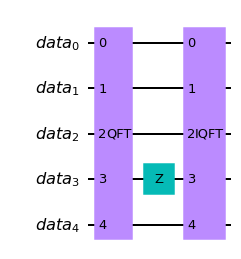

In [31]:
data_qubits = 5
qr_data = QuantumRegister(data_qubits, "data")
qc = QuantumCircuit(qr_data)
#qc.draw()
qc = qc.compose(QFT(data_qubits))
qc.z(3)
qc = qc.compose(QFT(data_qubits).inverse())
qc.draw()

In [32]:
def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_data)
    
    ##############################
    ### QFT ###
    # Provide your code here
    qc = qc.compose(QFT(data_qubits))
    
    
    ##############################

    ##############################
    ### Phase Rotation ###
    # Use `subroutine_add_const`
    qc = qc.compose(subroutine_add_const(data_qubits, const, to_gate))
    
    ##############################
    
    ##############################
    ### IQFT ###
    # Provide your code here
    qc = qc.compose(QFT(data_qubits).inverse())
    
    
    
    ##############################
    return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc

<div class="alert alert-block alert-success">

**Challenge 4c - Step 3**
    
</div>

Here we want to store the cost in a QRAM form: 

\begin{equation*}
\sum_{x\in\{0,1\}^t} \left|x\right\rangle\left|cost(x)\right\rangle
\end{equation*}

where $t$ is the number of time window (=size of index register), and $x$ is the pattern of battery choice through all the time window.

Given two lists $C^1 = \left[c_0^1, c_1^1, \cdots\right]$ and $C^2 = \left[c_0^2, c_1^2, \cdots\right]$, 
we can encode the "total sum of each choice" of these data using controlled gates by each index qubit.
If we want to add $c_i^1$ to the data whose $i$-th index qubit is $0$ and $c_i^2$ to the data whose $i$-th index qubit is $1$, 
then we can add $C_i^1$ to data register when the $i$-th qubit in index register is $0$,
and $C_i^2$ to data register when the $i$-th qubit in index register is $1$.
These operation can be realized by controlled gates.
If you want to create controlled gate from gate with type `qiskit.circuit.Gate`, the `control()` method might be useful.
<br>
<br>



Fill in the blank in the following cell to complete the `cost_calculation` function.

In [ ]:
def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_index, qr_data)

    for i, (val1, val2) in enumerate(zip(list1, list2)):
        
        ##############################
        ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
        # Provide your code here
        
        
        
        ##############################
        qc.x(qr_index[i])
        
        ##############################
        ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
        # Provide your code here
        
        
        
        ##############################
        qc.x(qr_index[i])
    
    return qc.to_gate(label=" Cost Calculation ") if to_gate else qc

<div class="alert alert-block alert-success">

**Challenge 4c - Step 4**
    
</div>

#### Constraint Testing

After the cost calculation process, we have gained the entangled QRAM with flag qubits set to zero for all indices:

\begin{equation*}
\sum_{x\in\{0,1\}^t} \left|x\right\rangle\left|cost(x)\right\rangle\left|0\right\rangle
\end{equation*}

In order to selectively add penalty to those indices with cost values larger than $C_{max}$, we have to prepare the following state:

\begin{equation*}
\sum_{x\in\{0,1\}^t} \left|x\right\rangle\left|cost(x)\right\rangle\left|cost(x)\geq C_{max}\right\rangle
\end{equation*}
<br>
<br>


Fill in the blank in the following cell to complete the `constraint_testing` function.

In [ ]:
def constraint_testing(data_qubits: int, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)
    
    ##############################
    ### Set the flag register for indices with costs larger than C_max ###
    # Provide your code here
    
    
    
    ##############################
    
    return qc.to_gate(label=" Constraint Testing ") if to_gate else qc

<div class="alert alert-block alert-success">

**Challenge 4c - Step 5**
    
</div>

#### Penalty Dephasing

We also have to add penalty to the indices with total costs larger than $C_{max}$ in the following way.

\begin{equation*}
\quad \quad \quad \quad \quad \quad penalty(z)=\left\{\begin{array}{ll}
0 & \text{if}\quad  cost(z)<C_{\max } \\
-\alpha\left(cost(z)-C_{\max }\right) & \text{if} \quad cost(z) \geq C_{\max }, \alpha>0 \quad \text{constant}
\end{array}\right.
\end{equation*}

This penalty can be described as quantum operator $e^{i \gamma \alpha\left(cost(z)-C_{\max }\right)}$.
<br>
To realize this unitary operator as quantum circuit, we focus on the following property.

\begin{equation*}
\alpha\left(cost(z)-C_{m a x}\right)=\sum_{j=0}^{k-1} 2^{j} \alpha A_{1}[j]-2^{c} \alpha
\end{equation*}

where $A_1$ is the quantum register for qram data, $A_1[j]$ is the $j$-th qubit of $A_1$, and $k$ and $c$ are appropriate constants.

Using this property, the penalty rotation part can be realized as rotation gates on each digit of data register of QRAM controlled by the flag register.
<br>
<br>


Fill in the blank in the following cell to complete the `penalty_dephasing` function.

In [ ]:
def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)
    
    ##############################
    ### Phase Rotation ###
    # Provide your code here
    
    
    
    ##############################
    
    return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc

<div class="alert alert-block alert-success">

**Challenge 4c - Step 6**
    
</div>

#### Reinitialization

The ancillary qubits such as the data register and the flag register should be reinitialized to zero states when the operator $U(C, \gamma_i)$ finishes.
<br>
If you want to apply inverse unitary of a `qiskit.circuit.Gate`, the `inverse()` method might be useful.
<br>
<br>


Fill in the blank in the following cell to complete the `reinitialization` function.

In [ ]:
def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_index, qr_data, qr_f)
    
    ##############################
    ### Reinitialization Circuit ###
    # Provide your code here
    
    
    
    ##############################
    
    return qc.to_gate(label=" Reinitialization ") if to_gate else qc

<div class="alert alert-block alert-success">

**Challenge 4c - Step 7**
    
</div>

### Mixing Operator $U(B, \beta_i)$

Finally, we have to add the mixing operator $U(B,\beta_i)$ after phase operator $U(C,\gamma_i)$.
The mixing operator can be represented as follows.
\begin{equation*}
U(B, \beta_i)=\exp (-i \beta_i B)=\prod_{i=j}^{n} \exp \left(-i \beta_i \sigma_{j}^{x}\right)
\end{equation*}

This operator can be realized by $R_x(2\beta_i)$ gate on each qubits in index register.
<br>
<br>

Fill in the blank in the following cell to complete the `mixing_operator` function.

In [ ]:
def mixing_operator(index_qubits: int, beta: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)
    
    ##############################
    ### Mixing Operator ###
    # Provide your code here
    
    
    
    ##############################
    
    return qc.to_gate(label=" Mixing Operator ") if to_gate else qc

<div class="alert alert-block alert-success">

**Challenge 4c - Step 8**
    
</div>

Finally, using the functions we have created above, we will make the submit function `solver_function` for whole relaxed QAOA process.


Fill the TODO blank in the following cell to complete the answer function.
- You can copy and paste the function you have made above.
- you may also adjust the number of qubits and its arrangement if needed.

In [ ]:
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    
    # the number of qubits representing answers
    index_qubits = len(L1)
    
    # the maximum possible total cost
    max_c = sum([max(l0, l1) for l0, l1 in zip(C1, C2)])
    
    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
    data_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2
    
    ### Phase Operator ###
    # return part
    def phase_return():
        ##############################
        ### TODO ###
        ### Paste your code from above cells here ###
        
        
        
        ##############################
    
    # penalty part
    def subroutine_add_const():
        ##############################
        ### TODO ###
        ### Paste your code from above cells here ###
        
        
        
        ##############################

    # penalty part
    def const_adder():
        ##############################
        ### TODO ###
        ### Paste your code from above cells here ###
        
        
        
        ##############################
    
    # penalty part
    def cost_calculation():
        ##############################
        ### TODO ###
        ### Paste your code from above cells here ###
        
        
        
        ##############################
    
    # penalty part
    def constraint_testing():
        ##############################
        ### TODO ###
        ### Paste your code from above cells here ###
        
        
        
        ##############################
    
    # penalty part
    def penalty_dephasing():
        ##############################
        ### TODO ###
        ### Paste your code from above cells here ###
        
        
        
        ##############################
        
    # penalty part
    def reinitialization():
        ##############################
        ### TODO ###
        ### Paste your code from above cells here ###
        
        
        
        ##############################

    ### Mixing Operator ###
    def mixing_operator():
        ##############################
        ### TODO ###
        ### Paste your code from above cells here ###
        
        
        
        ##############################
    
    qr_index = QuantumRegister(index_qubits, "index") # index register
    qr_data = QuantumRegister(data_qubits, "data") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_index = ClassicalRegister(index_qubits, "c_index") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_index, qr_data, qr_f, cr_index)
    
    ### initialize the index register with uniform superposition state ###
    qc.h(qr_index)
    
    ### DO NOT CHANGE THE CODE BELOW
    p = 5
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(index_qubits, gamma, L1, L2), qr_index)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(index_qubits, data_qubits, C1, C2), qr_index[:] + qr_data[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(data_qubits, C_max), qr_data[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(data_qubits, alpha, gamma), qr_data[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), qr_index[:] + qr_data[:] + qr_f[:])
        
        ### mixing operator ###
        qc.append(mixing_operator(index_qubits, beta), qr_index)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_index, cr_index[::-1])
    
    return qc

Validation function contains four input instances.
The output should pass the precision threshold 0.80 for the eight inputs before scored.

In [ ]:
# Execute your circuit with following prepare_ex4c() function.
# The prepare_ex4c() function works like the execute() function with only QuantumCircuit as an argument.
from qc_grader import prepare_ex4c
job = prepare_ex4c(solver_function)

result = job.result()

In [ ]:
# Check your answer and submit using the following code
from qc_grader import grade_ex4c
grade_ex4c(job)

### References
1. Edward Farhi and Jeffrey Goldstone and Sam Gutmann (2014). A Quantum Approximate Optimization Algorithm. (https://arxiv.org/abs/1411.4028)
2. Grand'rive, Pierre & Hullo, Jean-Francois (2019). Knapsack Problem variants of QAOA for battery revenue optimisation.  (https://arxiv.org/abs/1908.02210)
3. V. Vedral, A. Barenco, A. Ekert (1995). Quantum Networks for Elementary Arithmetic Operations. (https://arxiv.org/abs/quant-ph/9511018)
4. Steven A. Cuccaro, Thomas G. Draper, Samuel A. Kutin, David Petrie Moulton (2004). A new quantum ripple-carry addition circuit. (https://arxiv.org/abs/quant-ph/0410184)
5. Thomas G. Draper (2000). Addition on a Quantum Computer (https://arxiv.org/abs/quant-ph/0008033)
6. Lidia Ruiz-Perez, Juan Carlos Garcia-Escartin (2014). Quantum arithmetic with the Quantum Fourier Transform. (https://arxiv.org/abs/1411.5949)

## Additional information

**Created by:** Bo Yang, Hyungseok Chang, Sitong Liu, Kifumi Numata

**Version:** 1.0.1